# Fitting a local equilibrium model to foam scan data
This notebook explains how mathematical programming can be used to optimize the parameters of an implicit function. Here, I will use `Julia` language and the package `JuMP`. Here, the data is obtained in my last experiment with the low pressure core holder. The surfactant is 0.5 wt% active AOS in demi-water, and the career gas is nitrogen. The experiment was performed over a long period of time, so more than 100 data points were obtained. Some other parameters:
  - k= 1.969e-12 m^2
  - T= 22 degC
  - p_back= 25 bar
  - L_core= 0.17 m

In [1]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames, NLopt, PyCall, Optim, Calculus
@pyimport scipy.optimize as so
PyPlot.rc("font", family="sans")
PyPlot.rc("figure", figsize=(5,4))

INFO: Loading help data...


## Read the data file
First, I read the data table using the `DataFrames` package.

In [2]:
data1 = readtable("data_lowPT_AOS_analyzed.csv")

,uw,ug,dp_ave,mu_gas,mu_water,mu_foam
1,5.878298913828083e-6,7.631195317406847e-6,9.545421120921306,1.810220571389312e-5,0.00095376230809645,0.8185025971292214
2,1.1756597827656166e-5,7.779810270757168e-6,8.559882233333333,1.8092278541060536e-5,0.0009537745174529407,0.5075596973871044
3,1.763489674148425e-5,7.850235258951347e-6,7.681348082969433,1.8087723065739243e-5,0.0009537801460025846,0.3491520668143651
4,2.9391494569140415e-6,7.445380014638763e-6,10.7011094379085,1.8115253726238633e-5,0.0009537463759192275,1.1937298150590854
5,1.4695747284570208e-6,7.3827580780685635e-6,11.047093101587302,1.8119819893798986e-5,0.0009537408309505533,1.445620638776359
6,7.347873642285104e-7,1.1820563414304008e-5,11.057196430434782,1.8115070655984524e-5,0.0009537465985598759,1.020188051850802
7,7.347873642285104e-7,2.228999386502883e-5,13.922369607296138,1.814792408903922e-5,0.000953707042209356,0.7004573640716616
8,7.347873642285104e-7,6.277403647695971e-6,7.07647410834236,1.8083894670119588e-5,0.0009537848888863743,1.1690342711849033
9,2.9391494569140415e-6,9.713494231121294e-6,12.034611721175587,1.8127474879100765e-5,0.0009537315700561279,1.101830687128639
10,2.9391494569140415e-6,1.8458654268164073e-5,15.057763648769576,1.815671856449678e-5,0.0009536965863816396,0.8151834149266508


## Assign values to the physical parameters

In [5]:
# Viscosity data [Pa.s]
muw_all = float(data1[:mu_water])
mug_all = float(data1[:mu_gas])
# IFT value [N/m]
sigma_wg = 0.03;

## Experimental data

In [6]:
# Foam quality
ug_all = float(data1[:ug]) # [m/s]
uw_all = float(data1[:uw]) # [m/s]
u_all = ug_all+uw_all # [m/s]
fg_exp_all = ug_all./u_all # [-]
dp_all = float(data1[:dp_ave])
# Foam apparent viscosity [Pa.s]
muf_exp_all = float(data1[:mu_foam]) # [Pa.s]
n_data = length(ug_all)
println("Data is loaded.")

Data is loaded.


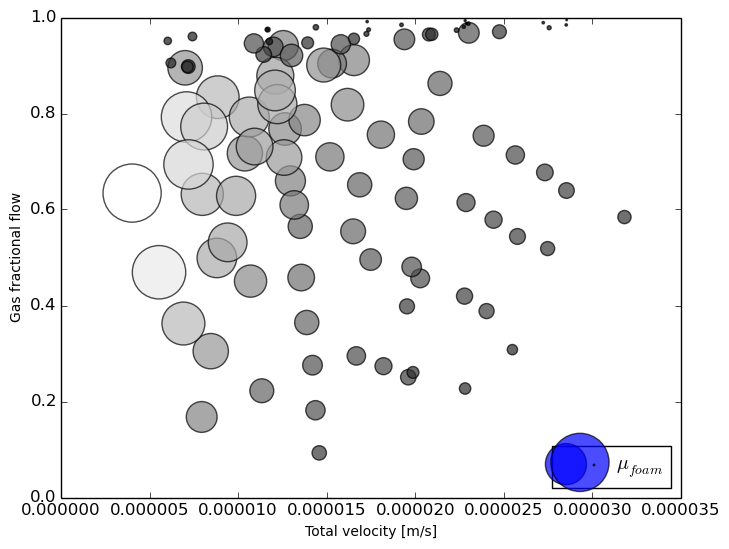

In [7]:
figure(figsize=(8,6))
scatter(u_all, fg_exp_all, s=π*(12*muf_exp_all).^2, c=muf_exp_all/maximum(muf_exp_all), alpha=0.7, cmap="gray")
xlabel("Total velocity [m/s]")
ylabel("Gas fractional flow")
axis([0, 0.000035, 0,1])
legend([L"\mu_{foam}"], loc=4);
#help(scatter);

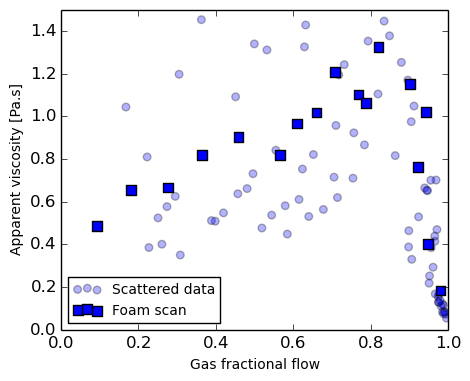

In [8]:
#plot(u,"o")
ind_u_mid=0.0000122.<u_all.<0.000015
ind_u_low=0.000017.<u_all.<0.000022
#u[ind_u_mid]
scatter(fg_exp_all[~ind_u_mid], muf_exp_all[~ind_u_mid], alpha=0.3, s=30)
scatter(fg_exp_all[ind_u_mid], muf_exp_all[ind_u_mid], s=50, marker="s")
#scatter(fg_exp_all[ind_u_low], muf_exp_all[ind_u_low], s=50, marker="v")
xlabel("Gas fractional flow")
ylabel("Apparent viscosity [Pa.s]")
legend(["Scattered data","Foam scan"], loc=3, fontsize=10)
axis([0,1,0,1.5]);

In [13]:
data2=data1[ind_u_mid,:]
writetable("data_lowPT_AOS_analyzed_SCAN.csv", data2)

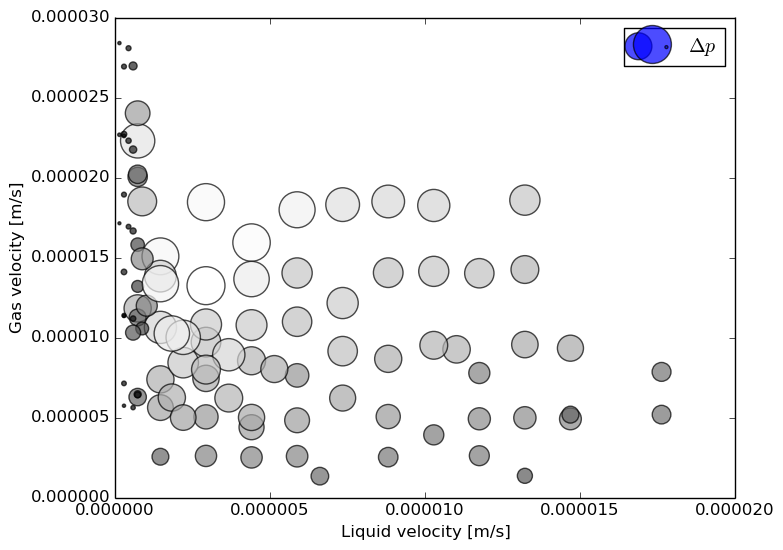

In [6]:
figure(figsize=(8,6))
scatter(uw_all, ug_all, s=π*(dp_all).^2, c=dp_all/maximum(dp_all), alpha=0.7, cmap="gray")
xlabel("Liquid velocity [m/s]")
ylabel("Gas velocity [m/s]")
axis([0, 0.000020, 0,0.000030])
legend([L"\Delta p"], loc=1);

## Relative permeability curves

In [8]:
# Relperm data
swc = 0.169997 
sgr = 0.0479002
krg0 = 0.94
ng = 1.8
krw0 = 0.336417 
nw = 2.49292  
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0));

## Visualize RelPerms

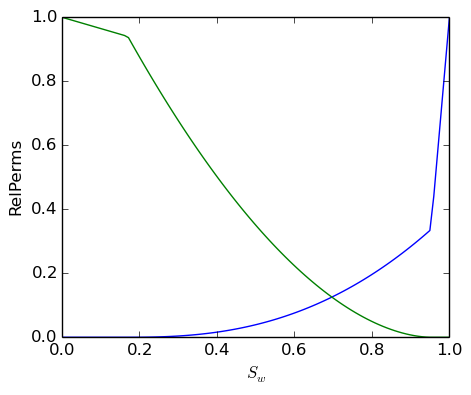

In [9]:
sw_plot = linspace(0.0,1.0, 100)
plot(sw_plot, krw(sw_plot), sw_plot, kr(sw_plot))
xlabel(L"S_w")
ylabel("RelPerms");

## Define the foam model

In [103]:
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2)=(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
  (F5[1]./(mu_f*u/sigma_wg)).^F5[2])
fm3(sw, F2, F5, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
  (F5[1]./(muw[1]*u/sigma_wg)).^F5[2])
fm4(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
  (F5[1]./(mu_f*u/sigma_wg)).^F5[2].*(F5[3]./u).^F5[4])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
krg3(sw, F2, F5, u)=(kr(sw)./fm3(sw, F2, F5, u))
krg4(sw, F2, F5, mu_f, u)=(kr(sw)./fm4(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
   krg2(sw,F2, F5, mu_f, u)/mug[1]));
fg3(sw, F2, F5, u)=((krg3(sw,F2, F5, u)/mug[1])./(krw(sw)/muw[1]+
   krg3(sw,F2, F5, u)/mug[1]));
fg4(sw, F2, F5, mu_f, u)=((krg4(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
   krg4(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u)=(1./(krw(sw)/muw[1]+
   krg2(sw, F2, F5, mu_f, u)/mug[1]))
mu_foam3(sw, F2, F5, u)=(1./(krw(sw)/muw[1]+
   krg3(sw, F2, F5, u)/mug[1]));
mu_foam4(sw, F2, F5, mu_f, u)=(1./(krw(sw)/muw[1]+
   krg4(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam4 (generic function with 1 method)

## Calculate the liquid saturation for data points

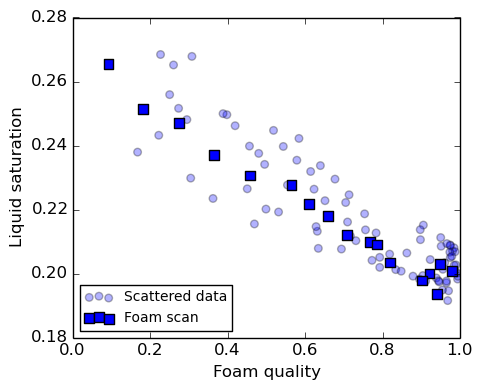

In [11]:
sw_exp_all = (1-swc-sgr)*(muw_all.*(1-fg_exp_all)./(krw0*muf_exp_all)).^(1/nw)+swc
labdaw_all = krw(sw_exp_all)./muw_all
labdag_all = kr(sw_exp_all)./mug_all
scatter(fg_exp_all[~ind_u_mid], sw_exp_all[~ind_u_mid], alpha=0.3, s=30)
scatter(fg_exp_all[ind_u_mid], sw_exp_all[ind_u_mid], s=50, marker="s")
xlabel("Foam quality")
ylabel("Liquid saturation")
legend(["Scattered data","Foam scan"], loc=3, fontsize=10)
axis([0,1,0.18,0.28]);

## Separate high and low quality data

In [12]:
ind_fg=sortperm(fg_exp_all[ind_u_mid])
sw_exp=sw_exp_all[ind_u_mid][ind_fg]
fg_exp=fg_exp_all[ind_u_mid][ind_fg]
muf_exp=muf_exp_all[ind_u_mid][ind_fg]
u=u_all[ind_u_mid][ind_fg]
muw=muw_all[ind_u_mid][ind_fg]
mug=mug_all[ind_u_mid][ind_fg]
labdaw=labdaw_all[ind_u_mid][ind_fg]
labdag=labdag_all[ind_u_mid][ind_fg]
# filter the low quality data for the low quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_low= find(fg_exp.<=fg_trans)
fg_low= fg_exp[ind_fg_low]
muf_low= muf_exp[ind_fg_low]
muw_low= muw[ind_fg_low]
# filter the high quality data for the high quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_high= find(fg_exp.>=fg_trans)
fg_high= fg_exp[ind_fg_high]
muf_high= muf_exp[ind_fg_high];

## Boeije-Rossen method

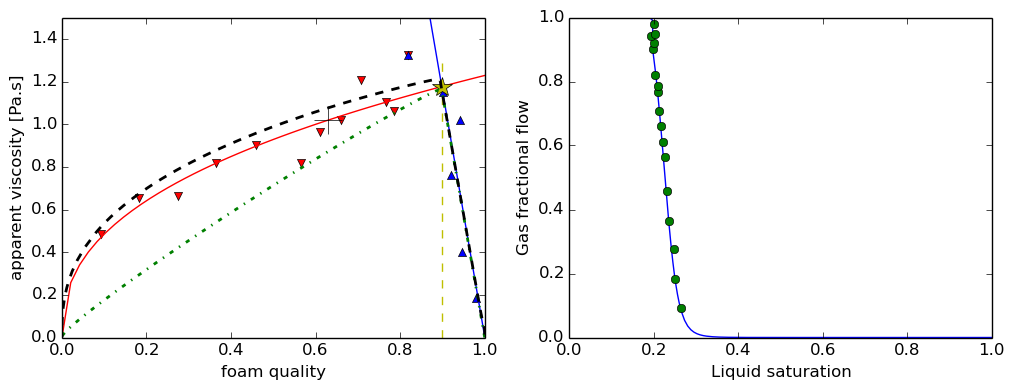

5-element Array{Float64,1}:
 987772.0       
 100000.0       
      0.197827  
      8.78794e-5
      1.47545   

In [13]:
# fit a line to the high quality data; note: y=a+b*x
w1=ones(length(fg_high)+1) # weight factor
w1[end]=100.0
w1[end-3:end-1]=20.0
a_high=linreg([fg_high;1.0], [muf_high;0.0], w1)
#a_high[1]=-a_high[2] # force it to go through point [1,0]
# fit a power law to the low quality data
# y=a*x^b; log(y)=log(a)+b*log(x)
w2=ones(length(fg_low)) # weight factor
w2[end-3:end]=1.0 # a larger weight to the points near the transition
a_low=linreg(log(fg_low),log(muf_low), w2)
fg_low_range=linspace(0.0, maximum(fg_low)+0.2, 50)
fg_high_range=linspace(maximum(fg_low),1.0, 10)
figure(figsize=[12,4])
subplot(1,2,1)
plot(fg_low, muf_low, "vr", fg_low_range, exp(a_low[1])*fg_low_range.^a_low[2], "r-")
plot(fg_high, muf_high, "b^", fg_high_range, a_high[1]+a_high[2]*fg_high_range, "b-")
# find the transition quality
fun1(x)=exp(a_low[1])*x^a_low[2]-(a_high[1]+a_high[2]*x)
fg_trans = fzero(fun1, maximum(fg_low))
muf_trans = a_high[1]+a_high[2]*fg_trans
plot(fg_trans, muf_trans, "*y", markersize=15, [fg_trans, fg_trans], [0.0, 1.1*muf_trans], "--y", linewidth=1)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
# find the transition saturation (or fmdry)
sw_trans = (1-swc-sgr)*(muw[ind_mu_max].*(1-fg_trans)./(krw0*muf_trans)).^(1/nw)+swc
fmdry_br= sw_trans
# find fmmob
FM_trans = mug[ind_mu_max]/muw[ind_mu_max]*fg_trans/(1-fg_trans)*(krw(sw_trans)/kr(sw_trans))
fmmob_br= 1.0/FM_trans-1.0
# find epdry
epdry_br= 100000.0 # very convenient
# visualize the three-parameter fit
x_br=[fmmob_br, epdry_br, fmdry_br]
sw_val = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
fg_opt = fg(sw_val, x_br)
muf_opt = mu_foam(sw_val, x_br)
plot(fg_opt, muf_opt, "-.g", linewidth=2)
# calculate the epcap
dryout(x, sw)=0.5+atan(x[1]*(sw-x[2]))/π
fg_plus=0.7*fg_trans
muf_plus= exp(a_low[1])*fg_plus^a_low[2]
plot(fg_plus, muf_plus, "k+", markersize=20)
sw_plus=(1-swc-sgr)*(muw[ind_mu_max].*(1-fg_plus)./(krw0*muf_plus)).^(1/nw)+swc
#FM_plus = mug[ind_mu_max]/muw[ind_mu_max]*fg_plus/(1-fg_plus)*(krw(sw_plus)/kr(sw_plus))
#epcap_br=log((1.0/FM_trans-1.0)/(1.0/FM_plus-1.0)*
#dryout([epdry_br,fmdry_br],sw_plus)/dryout([epdry_br,fmdry_br],sw_trans))/log(muf_plus/muf_trans)
epcap_br=log((kr(sw_trans)*muf_plus-fg_plus*mug[ind_mu_max])/
(fmmob_br*mug[ind_mu_max]*fg_plus))/log(muf_trans/muf_plus)
# calculate fmcap
ind_muf_min = indmin(muf_exp)
fmcap_br= muf_exp[ind_muf_min]*u[ind_muf_min]/sigma_wg
# correct for fmmob
fmmob_br_new = fmmob_br*(muf_trans/muf_exp[ind_muf_min])^epcap_br
# visualize the final results
x_br2= [fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]
sw_p = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n1 = length(sw_p)
muf_opt = zeros(n1)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n1
    fmu(x)= x-mu_foam2(sw_p[i], x_br2[1:3], x_br2[4:5], x, u_ave)
    muf_opt[i]=fzero(fmu, 0.9)
end
plot(fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), mu_foam2(sw_p, x_br2[1:3], 
x_br2[4:5], muf_opt, u_ave), "k--", linewidth=2)
axis([0,1,0,1.5])
subplot(1,2,2)
plot(sw_p, fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
fit_br=[fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]

## Calculate the experimental foam parameters
See our paper for more details.

In [14]:
#FM = mug./muw.*fg_exp./(1-fg_exp).*(krw(sw_exp)./kr(sw_exp))
FM = mug.*fg_exp./(kr(sw_exp).*muf_exp)
f_foam = 1.0./FM-1.0
FM_all = mug_all.*fg_exp_all./(kr(sw_exp_all).*muf_exp_all)
f_foam_all = 1.0./FM_all-1.0;

## Create and solve a JuMP model: three parameters

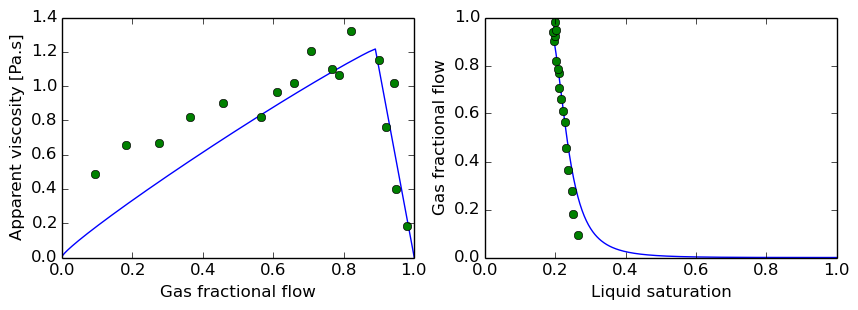

3-element Array{Float64,1}:
 66814.1     
 66700.1     
     0.197246

In [15]:
#m1 = Model(solver=IpoptSolver(print_level=1))
m1 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
#m = Model()
# define the variables of the foam model
@defVar(m1, 10<=fmmob<=5000000)
@defVar(m1, 100<=epdry<=100000, start=10000)
@defVar(m1, swc<=fmdry<=sw_exp[ind_mu_max])
n_data=length(muf_exp)
w=ones(n_data)
ind_mu_max= indmax(muf_exp)
w[ind_mu_max-1:ind_mu_max+1]=50
#@setNLObjective(m1, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
#@setNLObjective(m, Min, sum{w[i]*(tan(f_foam[i]/fmmob-0.5)-(epdry*(sw_exp[i]-fmdry))/pi)^2, i=1:n_data})
@setNLObjective(m1, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi))))^2, i=1:n_data})
solve(m1)
# get the result
x1 = [getValue(fmmob), getValue(epdry), getValue(fmdry)]
sw_val = linspace(0,1.0, 500)
fg_opt = fg(sw_val, x1)
muf_opt = mu_foam(sw_val, x1)
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg_opt, muf_opt, fg_exp, muf_exp, "o")
xlabel("Gas fractional flow")
ylabel("Apparent viscosity [Pa.s]")
subplot(1,2,2)
plot(sw_val, fg_opt, sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
x1

## Create and solve a JuMP model: five parameters

In [135]:
#m2 = Model(solver=IpoptSolver(print_level=1))
m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m2, 10<=fmmob<=5000000, start=x1[1])
@defVar(m2, 1000<=epdry<=100000, start=x1[2])
#@defVar(m2, swc<=fmdry<=sw_exp[ind_mu_max], start=x1[3])
@defVar(m2, fmdry==x1[3])
@defVar(m2, 1e-7<=fmcap<=1e-4)
@defVar(m2, 0.0<=epcap<=4.0)
n_data=length(muf_exp)
w=ones(n_data)
w[ind_mu_max+[0]]=100
#w[ind_mu_max+[1,2]]=0.01
#@setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2
#    +w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
 802478.0       
   1000.0       
      0.197246  
      1.36667e-5
      0.641975  

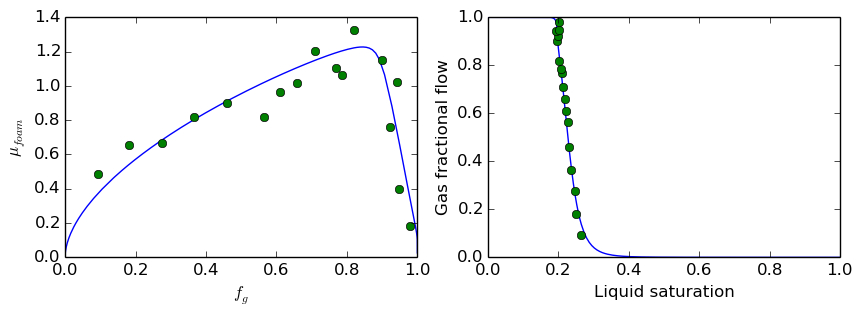

In [136]:
sw_plot = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_upper=so.fminbound(fmu, 0.0, 3.0)
    mu_lower=so.fminbound(fmu2, 0.0, 3.0)
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
end
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave))
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(1,2,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");

## Visualize the results
One method is to calculate the pressure drop in different gas and liquid rates, and plot the pressure drop contours versus gas and liquid velocity. The following result is visualized for a few average total flow rates.

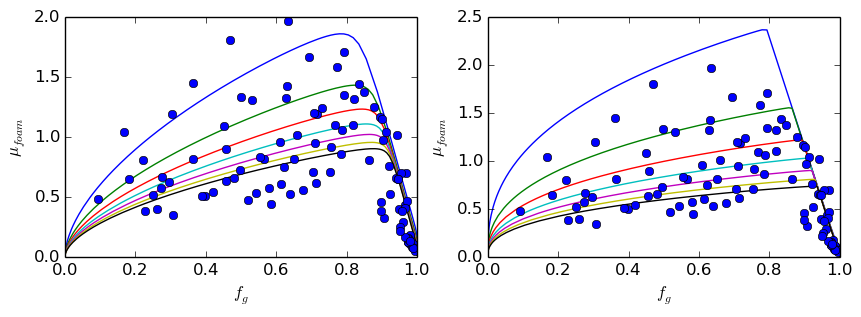

In [137]:
sw_plot = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u_all)
u_max = maximum(u_all)
u_ave = mean(u)
u_range = linspace(u_min, u_max, 7)
figure(figsize=[10,3])
subplot(1,2,1)
for U in u_range
    for i=1:n_plot
        fmu(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, U)
        muf_opt[i]=fzero(fmu, 0.5)
    end
    plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, U), mu_foam2(sw_plot, x2[1:3], 
    x2[4:5], muf_opt, U))
end
plot(fg_exp_all, muf_exp_all, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}");
# Boeije-Rossen result
subplot(1,2,2)
x2=fit_br
for U in u_range
    for i=1:n_plot
        fmu(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, U)
        muf_opt[i]=fzero(fmu, 0.5)
    end
    plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, U), mu_foam2(sw_plot, x2[1:3], 
    x2[4:5], muf_opt, U))
end
plot(fg_exp_all, muf_exp_all, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}");

## Use least-square on the whole dataset
This is the last stage. I'm using the least-square algorithm on the whole data set to find the optimum parameters.

In [166]:
#m3 = Model(solver=IpoptSolver(print_level=1))
m3 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m3, 10<=fmmob<=5000000, start=x1[1])
@defVar(m3, 1000<=epdry<=100000, start=x1[2])
@defVar(m3, swc<=fmdry<=sw_exp[ind_mu_max], start=x1[3])
#@defVar(m3, fmdry==0.1978)
@defVar(m3, 1e-7<=fmcap<=1e-4)
#@defVar(m3, fmcap==3e-5)
@defVar(m3, -3.0<=epcap<=4.0)
n_data=length(muf_exp_all)
ind_fg_w=0.7.<fg_exp_all.<0.85
w=ones(n_data)
w[ind_fg_w]=200
#@setNLObjective(m3, Min, sum{w[i]*(f_foam_all[i]-fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)
#    *(fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(FM_all[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)
#    *(fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m3, Min, sum{w[i]*(muf_exp_all[i]-1.0/(labdaw_all[i]+
    labdag_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap)))^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(fg_exp_all[i]-labdag_all[i]*
#    muf_exp_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(fg_exp_all[i]-labdag_all[i]*
#    muf_exp_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2
#    +w[i]*(muf_exp_all[i]-1.0/(labdaw_all[i]+
#    labdag_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap)))^2, i=1:n_data})

# solve it
solve(m3)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
     3.33338e6 
 70665.8       
     0.199722  
     7.04008e-5
     1.9836    

4.0175209090950096e-6
9.576353299194287e-6
1.5135185689293565e-5
2.0694018079392843e-5
2.625285046949212e-5
3.18116828595914e-5


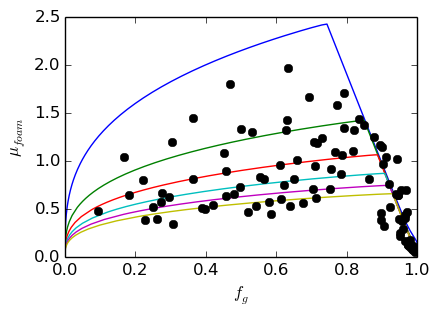

In [167]:
sw_plot = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u_all)
u_max = maximum(u_all)
u_ave = mean(u)
u_range = linspace(u_min, u_max, 6)
figure(figsize=[10,3])
subplot(1,2,1)
for U in u_range
    println(U)
    for i=1:n_plot
        fmu(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, U)
        #mu_guess=mu_foam(sw_plot[i], x2[1:3])
        muf_opt[i]=fzero(fmu, 5.0)
        #fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, U)-x
        #fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, U)
        #mu_upper=so.fminbound(fmu, 0.0, 4.0)
        #if sw_plot[i]<0.19
        #    mu_lower=0.0
        #else
        #    mu_lower=so.fminbound(fmu2, 0, 4.0)
        #end
        #    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
    end
    plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, U), mu_foam2(sw_plot, x2[1:3], 
    x2[4:5], muf_opt, U))
end
plot(fg_exp_all, muf_exp_all, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}");

# Five parameter linear
In the shear thinning term, I replace the apparent viscosity with liquid viscosity.

In [168]:
#m4 = Model(solver=IpoptSolver(print_level=1))
m4 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m4, 10<=fmmob<=5000000, start=x1[1])
@defVar(m4, 10<=epdry<=100000, start=x1[2])
@defVar(m4, swc<=fmdry<=sw_exp[ind_mu_max], start=x1[3])
#@defVar(m4, fmdry==x1[3])
@defVar(m4, 1e-7<=fmcap<=1e-4)
@defVar(m4, 0.0<=epcap<=4.0)
n_data=length(muf_exp)
w=ones(n_data)
w[ind_mu_max+[0,1,2,3]]=100
#w[ind_mu_max+[1,2]]=0.01
#@setNLObjective(m4, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muw[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m4, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
    *(fmcap/(u[i]*muw[i]/sigma_wg))^epcap)))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(fg_exp[i]-labdag[i]*
#    muf_exp[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2
#    +w[i]*(muf_exp[i]-1.0/(labdaw[i]+
#    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))^2, i=1:n_data})

# solve it
solve(m4)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
 74312.5       
 66677.6       
     0.200138  
     1.23436e-6
     0.0472489 

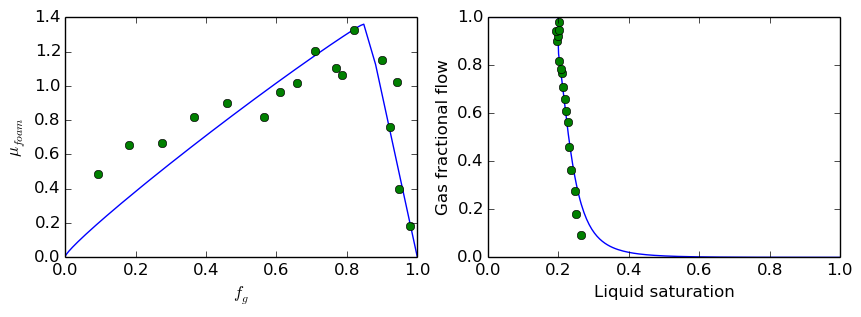

In [169]:
sw_plot = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg3(sw_plot, x2[1:3], x2[4:5], u_ave), mu_foam3(sw_plot, x2[1:3], 
x2[4:5], u_ave))
plot(fg_exp, muf_exp, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}")
subplot(1,2,2)
plot(sw_plot, fg3(sw_plot, x2[1:3], x2[4:5], u_ave), 
   sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow");

# Last try
The above for all data points

In [181]:
#m3 = Model(solver=IpoptSolver(print_level=1))
m3 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m3, 10<=fmmob<=5000000, start=x1[1])
@defVar(m3, 100<=epdry<=100000, start=x1[2])
#@defVar(m3, swc<=fmdry<=sw_exp[ind_mu_max], start=x1[3])
@defVar(m3, fmdry==0.1978)
@defVar(m3, 1e-7<=fmcap<=1e-4)
#@defVar(m3, fmcap==3e-5)
@defVar(m3, -3.0<=epcap<=4.0)
n_data=length(muf_exp_all)
ind_fg_w=0.7.<fg_exp_all.<0.85
w=ones(n_data)
w[ind_fg_w]=200
#@setNLObjective(m3, Min, sum{w[i]*(f_foam_all[i]-fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)
#    *(fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(FM_all[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)
#    *(fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m3, Min, sum{w[i]*(muf_exp_all[i]-1.0/(labdaw_all[i]+
    labdag_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
    (fmcap/(u_all[i]*muw_all[i]/sigma_wg))^epcap)))^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(fg_exp_all[i]-labdag_all[i]*
#    muf_exp_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(fg_exp_all[i]-labdag_all[i]*
#    muf_exp_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2
#    +w[i]*(muf_exp_all[i]-1.0/(labdaw_all[i]+
#    labdag_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap)))^2, i=1:n_data})

# solve it
solve(m3)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
     3.39849e6 
 99931.5       
     0.1978    
     1.72981e-5
    -1.02675   

4.0175209090950096e-6
9.576353299194287e-6
1.5135185689293565e-5
2.0694018079392843e-5
2.625285046949212e-5
3.18116828595914e-5


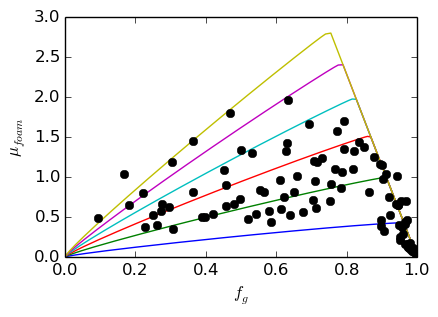

In [182]:
sw_plot = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u_all)
u_max = maximum(u_all)
u_ave = mean(u)
u_range = linspace(u_min, u_max, 6)
figure(figsize=[10,3])
subplot(1,2,1)
for U in u_range
    println(U)
    for i=1:n_plot
        muf_opt[i]=mu_foam3(sw_plot[i], x2[1:3], x2[4:5], U)
    end
    plot(fg3(sw_plot, x2[1:3], x2[4:5], U), mu_foam3(sw_plot, x2[1:3], 
    x2[4:5], U))
end
plot(fg_exp_all, muf_exp_all, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}");

# The shear thinning term
The capillary term is not enough to capture the shear thinning behaviour of foam. So I'm adding one extra shear thinning term to the model.

In [178]:
m3 = Model(solver=IpoptSolver(print_level=1))
u_min=minimum(u_all)
u_max=maximum(u_all)
#m3 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@defVar(m3, 10<=fmmob<=5000000, start=x1[1])
@defVar(m3, 10<=epdry<=100000, start=x1[2])
#@defVar(m3, swc<=fmdry<=sw_exp[ind_mu_max], start=x1[3])
@defVar(m3, fmdry==0.1978)
@defVar(m3, 1e-7<=fmcap<=1e-4)
@defVar(m3, u_min<=fmsh<=u_max)
#@defVar(m3, fmcap==3e-5)
@defVar(m3, -3.0<=epcap<=4.0)
@defVar(m3, 0.0<=epsh<=2.0)
n_data=length(muf_exp_all)
ind_fg_w=0.8.<fg_exp_all.<0.98
w=ones(n_data)
w[ind_fg_w]=10
#@setNLObjective(m3, Min, sum{w[i]*(f_foam_all[i]-fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)
#    *(fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(FM_all[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)
#    *(fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2, i=1:n_data})
@setNLObjective(m3, Min, sum{w[i]*(muf_exp_all[i]-1.0/(labdaw_all[i]+
    labdag_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap*(fmsh/u_all[i])^epsh)))^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(fg_exp_all[i]-labdag_all[i]*
#    muf_exp_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m3, Min, sum{w[i]*(fg_exp_all[i]-labdag_all[i]*
#    muf_exp_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap))^2
#    +w[i]*(muf_exp_all[i]-1.0/(labdaw_all[i]+
#    labdag_all[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp_all[i]-fmdry))/pi)*
#    (fmcap/(u_all[i]*muf_exp_all[i]/sigma_wg))^epcap)))^2, i=1:n_data})

# solve it
solve(m3)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap), getValue(fmsh), getValue(epsh)]

7-element Array{Float64,1}:
 19581.5       
    23.3548    
     0.1978    
     6.96684e-5
    -1.1193    
     9.53439e-6
     1.12143   

In [105]:
x2

7-element Array{Float64,1}:
 19581.5       
    23.3548    
     0.1978    
     6.96684e-5
    -1.1193    
     9.53439e-6
     1.12143   

In [179]:
sw_plot = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u_all)
u_max = maximum(u_all)
u_ave = mean(u)
u_range = linspace(u_min, u_max, 6)
figure(figsize=[10,3])
subplot(1,2,1)
for U in u_range
    println(U)
    for i=1:n_plot
        fmu(x)= x-mu_foam4(sw_plot[i], x2[1:3], x2[4:7], x, U)
        #mu_guess=mu_foam(sw_plot[i], x2[1:3])
        println(fmu(5.0))
        muf_opt[i]=fzero(fmu, 5.0)
        #fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, U)-x
        #fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, U)
        #mu_upper=so.fminbound(fmu, 0.0, 4.0)
        #if sw_plot[i]<0.19
        #    mu_lower=0.0
        #else
        #    mu_lower=so.fminbound(fmu2, 0, 4.0)
        #end
        #    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
    end
    plot(fg4(sw_plot, x2[1:3], x2[4:7], muf_opt, U), mu_foam4(sw_plot, x2[1:3], 
    x2[4:7], muf_opt, U))
end
plot(fg_exp_all, muf_exp_all, "o")
xlabel(L"f_g")
ylabel(L"\mu_{foam}");

4.0175209090950096e-6
4.203224817748811


LoadError: DomainError
while loading In[179], in expression starting on line 11

In [180]:
mu_foam4(0.3, x2[1:3], x2[4:7], 5, 1e-5)

0.24448609844331834